In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
from scipy.special import voigt_profile
import importlib
plt.rcParams["font.family"] = "Times New Roman"

In [4]:
#input parameters

file = "77K_Section_A.xlsx"
sheets = ["9830"]
cols = ["WS_0","WS_1","WS_2","WS_3","WS_4","WS_5","WS_6","WS_7"]
start_index = 9830

In [5]:
#helper functions

def reduced_chi_squared(xdata, ydata, yerror, model, model_fit_parameters):
    dof = len(ydata)-len(model_fit_parameters)
    theoretical = model(xdata,*model_fit_parameters)
    chi2 = np.sum(((ydata-theoretical)/yerror)**2)
    return chi2/dof

def wavelength_extraction(x, start_index):
    A = 0.9958
    alpha_A = 0.0001

    B = 9096.6280
    alpha_B = 0.0289

    wavelengths = []
    uncertainties = []

    for i in range(len(x)):
        wavelength = (start_index - 0.242*x[i] - B) / A
        uncertainty = np.abs((x[i] - (B + alpha_B)) / (A + alpha_A) - wavelength)

        wavelengths.append(wavelength)
        uncertainties.append(uncertainty)

    return wavelengths

def voigt_model_double(x, A1, center1, gamma1, sigma,
                                 A2, center2, gamma2, offset):
    return (
            A1 * voigt_profile(x - center1, sigma, gamma1) +
            A2 * voigt_profile(x - center2, sigma, gamma2) +
            offset
        )

In [6]:
########

#Pipeline

#Plan:
# 1) take the raw intensity data, produce a plot of intensity against wavelength
# 2) normalise all of the plots such that the area matches the area of one of them
# 3) fit a double voigt profile to an area of the dataset that I can specify (ensures we fit the R1 and R2 and not the other transitions)
# 4) produce the relevant summary statistcs
#########

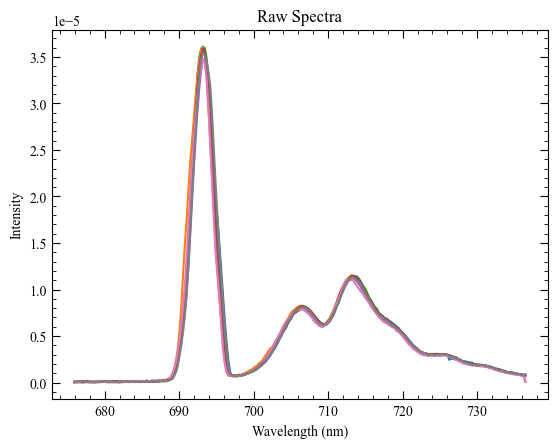

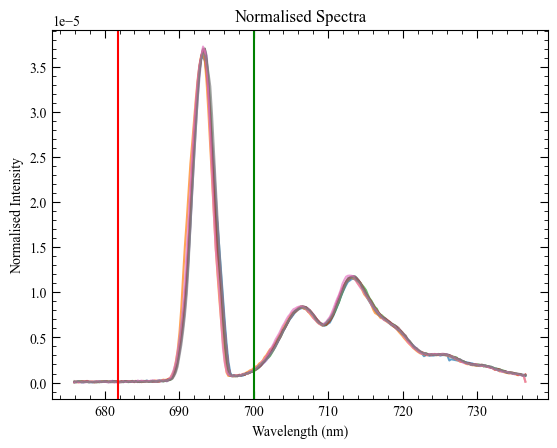

In [7]:
#implement step 1

#extract wavelengths
df = pd.read_excel(file,sheet_name = sheets[0])
index = np.arange(0, len(df[cols[0]]), 1)

wavelengths = wavelength_extraction(index, start_index)

#plot raw spectra
plt.figure(1)
for col in cols:
    plt.plot(wavelengths, df[col], label=col)

plt.title("Raw Spectra")
plt.ylabel("Intensity")
plt.xlabel("Wavelength (nm)")

plt.minorticks_on()
plt.tick_params(which='major', direction='in',
                    top=True, bottom=True, left=True, right=True, size=6)
plt.tick_params(which='minor', direction='in',
                    top=True, bottom=True, left=True, right=True, size=3)

plt.show()

#normalise spectra such that the area matches that of the first column (step 2)

dx = np.abs(index[1] - index[0])
area_0 = np.sum(df[cols[0]]*dx)

normalised_spectra = []

plt.figure()
for col in cols:
    spectrum = df[col].to_numpy()
    norm_spec = (spectrum / np.sum(spectrum * dx)) * area_0
    normalised_spectra.append(norm_spec)
    plt.plot(wavelengths, norm_spec, alpha=0.7)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity")
plt.ylabel("Normalised Intensity")
plt.title("Normalised Spectra")
plt.minorticks_on()
plt.tick_params(which='major', direction='in',
                    top=True, bottom=True, left=True, right=True, size=6)
plt.tick_params(which='minor', direction='in',
                    top=True, bottom=True, left=True, right=True, size=3)

plt.axvline(wavelengths[225], color = 'red')
plt.axvline(wavelengths[150], color = 'green')
plt.show()

#create an averaged data frame for all of the spectra

intensity_matrix = np.column_stack(normalised_spectra)
intensity_data = np.mean(intensity_matrix, axis = 1)
intensity_error = np.std(intensity_matrix, axis = 1)/np.sqrt(len(cols))

In [8]:
#implement step 3 (fitting the double voigt profile around R1 and R2):

padding = [164,225] #min max wavelength indexes

center2_guess = wavelengths[np.argmax(intensity_data)]
center1_guess = center2_guess - 1.4

p0_double = [
    intensity_data.max()/2, #Guess A1
    center1_guess, #center1
    0.3, #gamma1
    0.3, #sigma
    intensity_data.max()/2, #Guess A2
    center2_guess, #center2
    0.3, #gamma2
    np.min(intensity_data), #offset
]

bounds_double = [[
    0, #Guess A1
    wavelengths[padding[1]], #center1
    0, #gamma1
    0, #sigma
    0, #Guess A2
    wavelengths[padding[1]], #center2
    0, #gamma2
    -np.inf, #offset
],[
    np.inf, #Guess A1
    wavelengths[padding[0]], #center1
    np.inf, #gamma1
    np.inf, #sigma
    np.inf, #Guess A2
    wavelengths[padding[0]], #center2
    np.inf, #gamma2
    np.inf, #offset
]]

pop, cov = curve_fit(voigt_model_double,
                     xdata= wavelengths[padding[0]:padding[1]],
                     ydata= intensity_data[padding[0]:padding[1]],
                     sigma= intensity_error[padding[0]:padding[1]],
                     absolute_sigma=True,
                     p0 = p0_double,
                     bounds = bounds_double)

norm_residuals = (intensity_data[padding[0]:padding[1]] - voigt_model_double(wavelengths[padding[0]:padding[1]], *pop))/intensity_error[padding[0]:padding[1]]

rchi2 = reduced_chi_squared(wavelengths[padding[0]:padding[1]], #xdata
                            intensity_data[padding[0]:padding[1]], #ydata
                            intensity_error[padding[0]:padding[1]], #yerror
                            voigt_model_double, #model
                            pop #model fit params
                            )

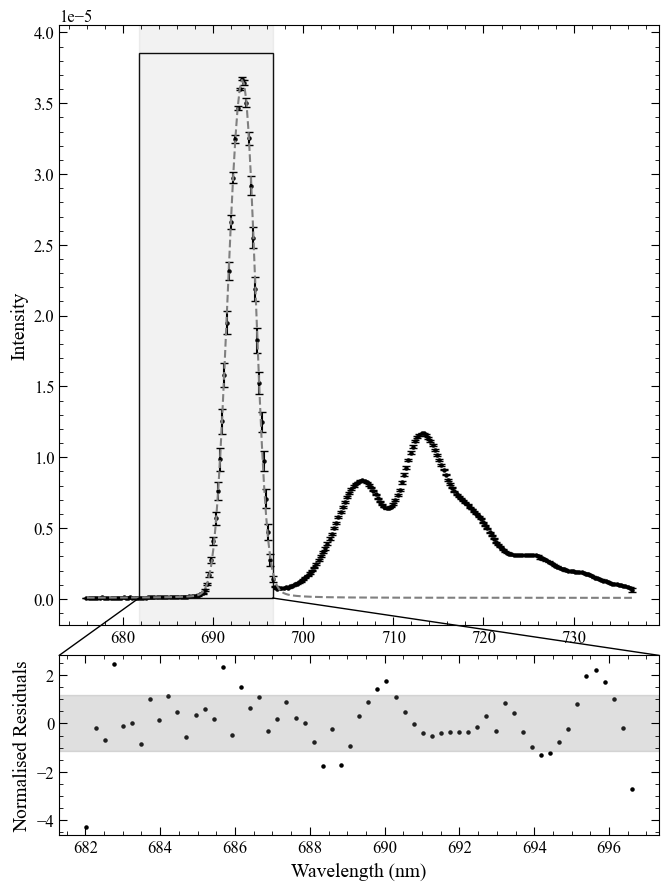

------ Summary Statistics ------
Reduced Chi Squared: 1.5502
----- R1 -----
R1 Theoretical: 694.3
R1 Observed: 693.7584 ± 0.05931489899016316
R1 Amp Frac: 0.6398620134764015
----- R2 -----
R2 Theoretical: 692.9
R2 Observed: 692.1374 ± 0.0742574074065359
R2 Amp Frac: 0.3601379865235986


In [9]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

plt.rcParams.update({
    "font.size": 14,          # Base font size
    "axes.titlesize": 14,     # Title
    "axes.labelsize": 14,     # Axis labels
    "xtick.labelsize": 12,    # X ticks
    "ytick.labelsize": 12,    # Y ticks
    "legend.fontsize": 12,    # Legend
    "figure.titlesize": 14
})

# Create figure and main axis
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_axes([0,0,1,1])

# --- Main plot ---
ax1.scatter(wavelengths, intensity_data, c='black', s=5)
ax1.errorbar(wavelengths, intensity_data,
             yerr=intensity_error,
             linestyle="none",
             color="black",
             capsize=3)

ax1.plot(wavelengths,
         voigt_model_double(wavelengths, *pop),
         color="grey",
         linestyle="--")

ax1.set_ylabel("Intensity")

ax1.minorticks_on()
ax1.tick_params(which='major', direction='in',
                top=True, bottom=True, left=True, right=True, size=6)
ax1.tick_params(which='minor', direction='in',
                top=True, bottom=True, left=True, right=True, size=3)


# --- Residual inset ---
ax2 = inset_axes(ax1,
                 width="100%",
                 height="30%",
                 loc="lower left",
                 bbox_to_anchor=(0, -0.35, 1, 1),
                 bbox_transform=ax1.transAxes,
                 borderpad=0)

# Define x-range of inset
x1 = wavelengths[padding[0]]
x2 = wavelengths[padding[1]]

# Define y-range (use your data range)
y1 = 0.9*min(intensity_data)
y2 = 1.05*max(intensity_data)

from matplotlib.patches import Rectangle
from matplotlib.patches import ConnectionPatch

# Rectangle showing inset region
rect = Rectangle(
    (x1, y1),
    x2 - x1,
    y2 - y1,
    linewidth=1,
    edgecolor='black',
    facecolor='none'
)

ax1.add_patch(rect)

# Define y-range (use your data range)
y1 = min(intensity_data)
y2 = max(intensity_data)

# Draw rectangle showing inset region
ax1.axvspan(x1, x2, alpha=0.1, color='grey')

# Connector lines
con1 = ConnectionPatch(
    xyA=(x2, y1), coordsA=ax1.transData,
    xyB=(0, 1), coordsB=ax2.transAxes,
    color="black"
)

con2 = ConnectionPatch(
    xyA=(x1, y1), coordsA=ax1.transData,
    xyB=(1, 1), coordsB=ax2.transAxes,
    color="black"
)

fig.add_artist(con1)
fig.add_artist(con2)

ax2.scatter(wavelengths[padding[0]:padding[1]],
            norm_residuals,
            s=5,
            color="black")

ax2.axhspan(-np.std(norm_residuals),
            np.std(norm_residuals),
            color="grey",
            alpha=0.25)

ax2.set_xlabel("Wavelength (nm)")
ax2.set_ylabel("Normalised Residuals")

ax2.minorticks_on()
ax2.tick_params(which='major', direction='in',
                top=True, bottom=True, left=True, right=True, size=6)
ax2.tick_params(which='minor', direction='in',
                top=True, bottom=True, left=True, right=True, size=3)

plt.show()

print(f"------ Summary Statistics ------")
print(f"Reduced Chi Squared: {rchi2:.4f}")

if pop[0] > pop[5]:
    print(f"----- R1 -----")
    print(f"R1 Theoretical: 694.3")
    print(f"R1 Observed: {pop[1]:.4f} ± {np.sqrt(cov[1][1])}")
    print(f"R1 Amp Frac: {pop[0]/(pop[0]+pop[4])}")
    print(f"----- R2 -----")
    print(f"R2 Theoretical: 692.9")
    print(f"R2 Observed: {pop[5]:.4f} ± {np.sqrt(cov[5][5])}")
    print(f"R2 Amp Frac: {pop[4]/(pop[0]+pop[4])}")
else:
    print(f"----- R1 -----")
    print(f"R1 Theoretical: 694.3")
    print(f"R1 Observed: {pop[5]:.4f} ± {np.sqrt(cov[5][5])}")
    print(f"R1 Amp Frac: {pop[4]/(pop[0]+pop[4])}")
    print(f"----- R2 -----")
    print(f"R2 Theoretical: 692.9")
    print(f"R2 Observed: {pop[1]:.4f} ± {np.sqrt(cov[1][1])}")
    print(f"R2 Amp Frac: {pop[0]/(pop[0]+pop[4])}")
